<a href="https://www.kaggle.com/code/les1781/backpack-prediction-playground-series-s5-e2?scriptVersionId=232956959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


# Libraries

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    RobustScaler
)
from sklearn.feature_selection import (
    mutual_info_regression
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error
)
from sklearn.ensemble import (
    ExtraTreesRegressor, 
    BaggingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# Backpack Prediction Challenge

### Playground Series - Season 5, Episode 2

### Overview

Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: Predict the price of backpacks given various attributes.

### Evaluation

Root Mean Squared Error (RMSE)
Submissions are scored on the root mean squared error.

### Submission File

For each id in the test set, you must predict the Price of the backpack. The file should contain a header and have the following format:

id,Price
300000,81.411
300001,81.411
300002,81.411
etc.

### Timeline

Start Date - February 1, 2025
Entry Deadline - Same as the Final Submission Deadline
Team Merger Deadline - Same as the Final Submission Deadline
Final Submission Deadline - February 28, 2025

In [3]:
# We load the data

play_train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")

In [4]:
play_train.shape

(300000, 11)

In [5]:
play_train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [6]:
play_train.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


In [7]:
play_train.describe(exclude = np.number)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,290295,291653,293405,292556,292950,292030,290050
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,60077,79630,101906,148342,148077,100031,51690


In [8]:
play_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


# EDA

In [9]:
# Function to view the data of each variable in detail

def detail_columns(data, colum):

    print(
        "Variable: ", colum,
        "\nFormat: ", data[colum].dtype,
        "\nNumber of null values: ", data[colum].isnull().sum(),
        "\nUnique values: ", data[colum].nunique(),
        "\nDistribution of values: \n", data[colum].value_counts()
    )

## id & Brand

In [10]:
detail_columns(play_train, "id")
print("-"* 39)
detail_columns(play_train, "Brand")

Variable:  id 
Format:  int64 
Number of null values:  0 
Unique values:  300000 
Distribution of values: 
 id
0         1
199988    1
200004    1
200003    1
200002    1
         ..
99999     1
99998     1
99997     1
99996     1
299999    1
Name: count, Length: 300000, dtype: int64
---------------------------------------
Variable:  Brand 
Format:  object 
Number of null values:  9705 
Unique values:  5 
Distribution of values: 
 Brand
Adidas          60077
Under Armour    59992
Nike            57336
Puma            56814
Jansport        56076
Name: count, dtype: int64


We initially found the two variables to identify the product and the brands. We see a percentage of null data for the brands variable. We could manage those values ​​as the "Other" brand, but we will analyze it further.

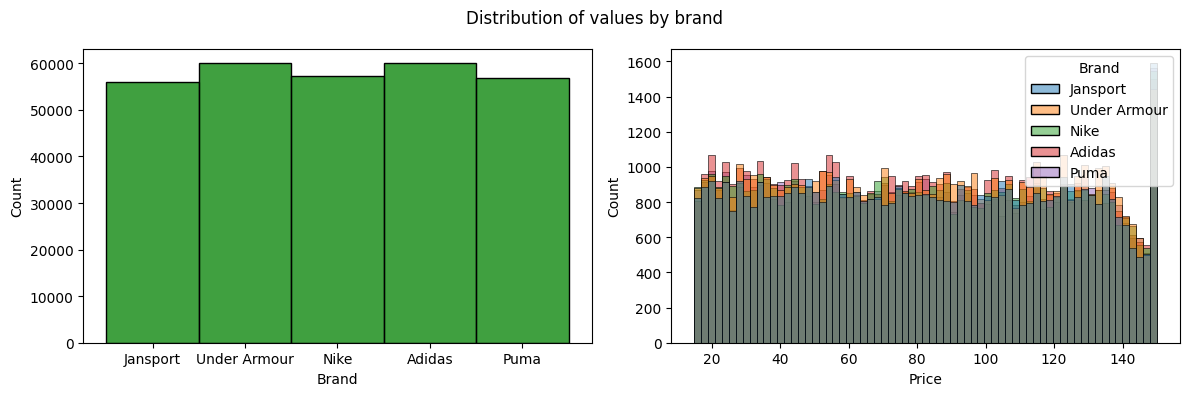

In [11]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=play_train, 
    x="Brand", 
    color="green",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Price",
    hue="Brand",
    edgecolor="k",
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by brand")
plt.tight_layout()
plt.show()

## Material & Waterproof

In [12]:
detail_columns(play_train, "Material")
print("-"* 39)
detail_columns(play_train, "Waterproof")

Variable:  Material 
Format:  object 
Number of null values:  8347 
Unique values:  4 
Distribution of values: 
 Material
Polyester    79630
Leather      73416
Nylon        70603
Canvas       68004
Name: count, dtype: int64
---------------------------------------
Variable:  Waterproof 
Format:  object 
Number of null values:  7050 
Unique values:  2 
Distribution of values: 
 Waterproof
Yes    148077
No     144873
Name: count, dtype: int64


Again we find null values in both variables. In the case of materials, we could take the value "other". For the endurance we will evaluate these data with other variables, especially material, to identify if they are missing values, and in that case complete the values in the most appropriate way.

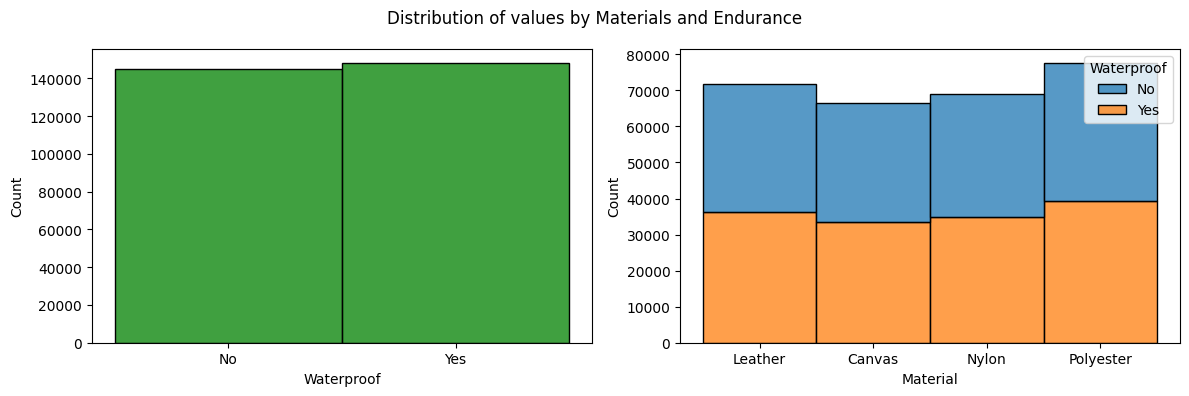

In [13]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=play_train, 
    x="Waterproof",
    color="green",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Material", 
    hue="Waterproof",
    multiple="stack",
    edgecolor="k",
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Materials and Endurance")
plt.tight_layout()
plt.show()

In [14]:
wp_nulls = play_train.loc[play_train["Waterproof"].isnull()]

wp_nulls.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
22,22,Puma,Nylon,Large,7.0,Yes,NaN,Backpack,Gray,17.181182,132.68502
105,105,Jansport,Nylon,Medium,2.0,Yes,NaN,Backpack,Green,13.067869,34.03546
119,119,Puma,Leather,Large,6.0,No,NaN,Tote,Gray,25.217609,76.17432
191,191,Jansport,Canvas,Medium,8.0,Yes,NaN,Tote,Red,12.882365,64.93777
237,237,Jansport,Leather,Large,9.0,Yes,NaN,Backpack,Blue,10.313950,17.43222


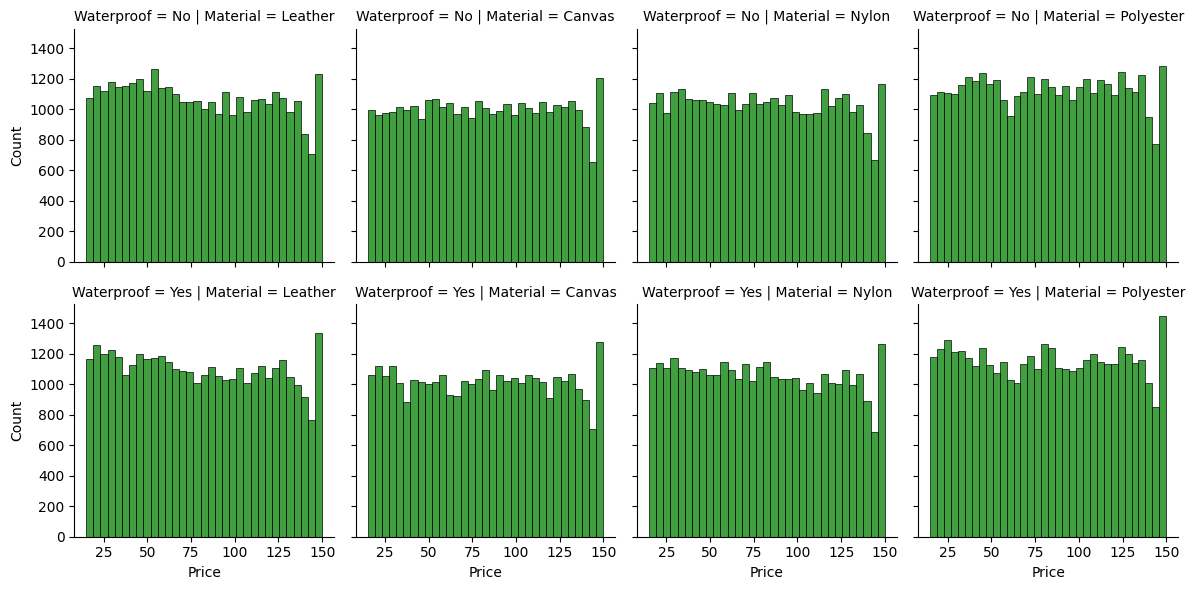

In [15]:
fig_nulls = sns.FacetGrid(play_train, col="Material", row="Waterproof")
fig_nulls.map(sns.histplot, "Price", color="green", edgecolor="k")
plt.show()

Analyzing both variables with other features, mainly the price, we did not find any relevant data as a guide to complete these missing values. We will take the value "Other" for the materials and the mode grouped by materials for "Waterproof", considering that there are no differences with the materials either.

## Compartments & Laptop Compartment

In [16]:
detail_columns(play_train, "Compartments")
print("-"* 39)
detail_columns(play_train, "Laptop Compartment")

Variable:  Compartments 
Format:  float64 
Number of null values:  0 
Unique values:  10 
Distribution of values: 
 Compartments
1.0     31568
4.0     31498
2.0     30595
3.0     30293
7.0     30158
9.0     29965
5.0     29959
10.0    29815
8.0     28909
6.0     27240
Name: count, dtype: int64
---------------------------------------
Variable:  Laptop Compartment 
Format:  object 
Number of null values:  7444 
Unique values:  2 
Distribution of values: 
 Laptop Compartment
Yes    148342
No     144214
Name: count, dtype: int64


We did not find null values for the compartments variable, but we did find null values for the specific compartment for the laptop. These data are clearly missing values, we could fill them in by evaluating the variable with size and bins, to define its value.

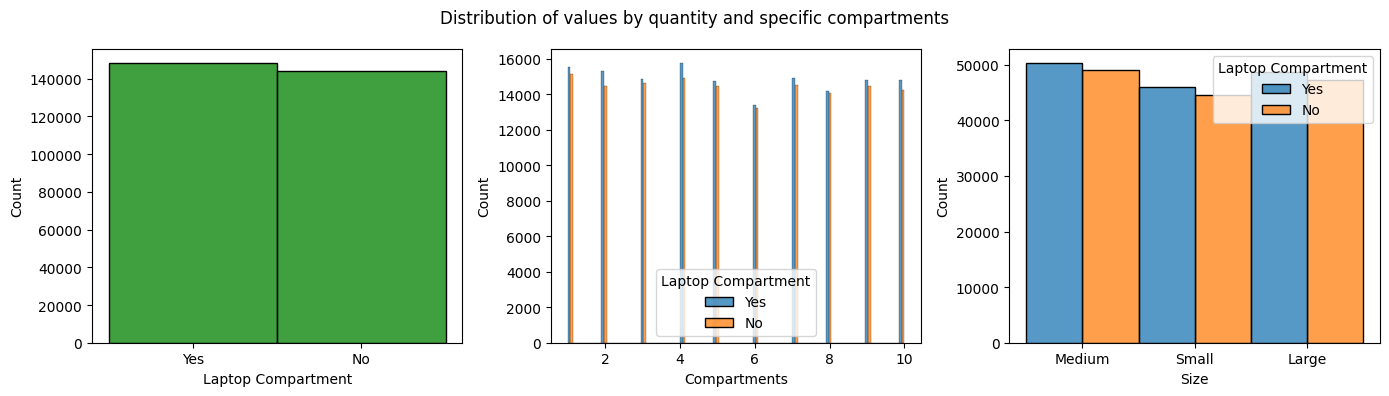

In [17]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

sns.histplot(
    data=play_train, 
    x="Laptop Compartment", 
    color="green",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Compartments",
    hue="Laptop Compartment",
    multiple="dodge", 
    edgecolor="k",
    ax=axes[1]
)

sns.histplot(
    data=play_train, 
    x="Size",
    hue="Laptop Compartment", 
    multiple="dodge",
    color="green",
    edgecolor="k",
    ax=axes[2]
)

plt.suptitle(
    t="Distribution of values by quantity and specific compartments"
)
plt.tight_layout()
plt.show()

We did not find any data that allows us to define the null values of the "laptop Comparment" variable. We did not find differences by size or number of compartments. We will use the mode to complete the values. Using a grouping by compartment or size would not make sense, since from the graph we can see that the values would all be 'yes'. We could try grouping by weight capacity.

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

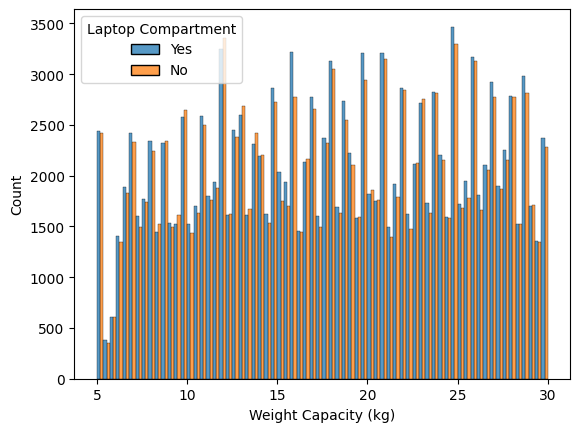

In [18]:
sns.histplot(
    data=play_train, 
    x="Weight Capacity (kg)",
    hue="Laptop Compartment",
    multiple="dodge", 
    edgecolor="k"
)

## Size & Weight Capacity (kg)

In [19]:
detail_columns(play_train, "Size")
print("-"* 39)
detail_columns(play_train, "Weight Capacity (kg)")

Variable:  Size 
Format:  object 
Number of null values:  6595 
Unique values:  3 
Distribution of values: 
 Size
Medium    101906
Large      98643
Small      92856
Name: count, dtype: int64
---------------------------------------
Variable:  Weight Capacity (kg) 
Format:  float64 
Number of null values:  138 
Unique values:  181596 
Distribution of values: 
 Weight Capacity (kg)
5.000000     4286
30.000000     185
11.898250     123
22.898382     116
14.908437     101
             ... 
6.938551        1
8.093085        1
22.013824       1
13.246538       1
6.175738        1
Name: count, Length: 181596, dtype: int64


We found some null values in the size variable, and very few in the variable that establishes the weight of the product, which we could fill with the mean or mode of the weight in relation to its size. Regarding missing size values, we could use the same logic based on weight.

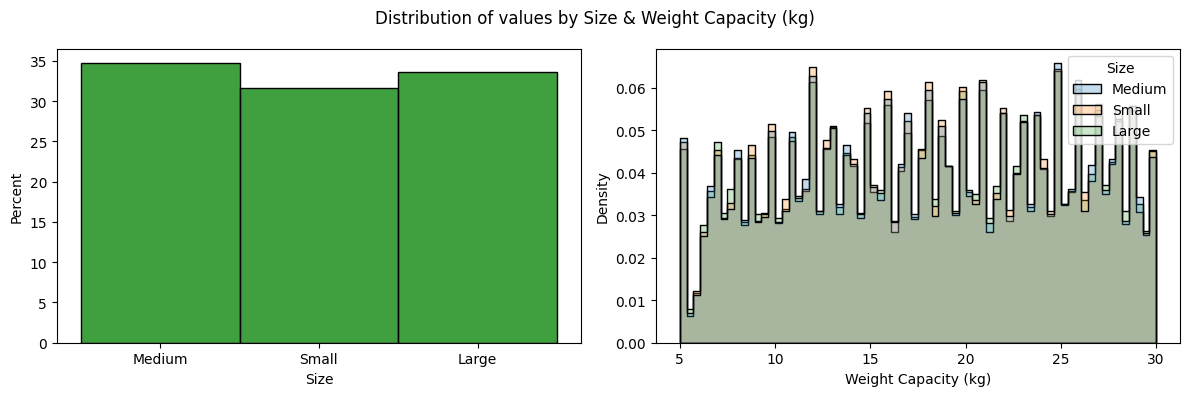

In [20]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=play_train, 
    x="Size", 
    stat="percent", 
    discrete=True,
    color="green",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Weight Capacity (kg)",
    hue="Size",
    element="step",
    stat="density", 
    common_norm=False,
    edgecolor="k",
    ax=axes[1]
)

plt.suptitle(
    t="Distribution of values by Size & Weight Capacity (kg)"
)
plt.tight_layout()
plt.show()

In [21]:
wc_nulls = play_train.loc[play_train["Weight Capacity (kg)"].isnull()]

wc_nulls.head(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
3168,3168,NaN,Polyester,Large,1.0,No,No,Messenger,NaN,NaN,96.84190
4202,4202,Nike,Leather,NaN,1.0,Yes,No,NaN,Black,NaN,20.40842
6314,6314,NaN,Polyester,Large,8.0,No,Yes,Backpack,Red,NaN,149.68126
7102,7102,NaN,Polyester,Medium,2.0,NaN,No,Tote,Pink,NaN,131.45734
10006,10006,Adidas,NaN,Large,10.0,Yes,No,NaN,Red,NaN,113.26874
12216,12216,Nike,Nylon,Small,1.0,No,NaN,Tote,Black,NaN,58.79253
19629,19629,Under Armour,NaN,Large,9.0,NaN,Yes,Messenger,Gray,NaN,144.71413
20291,20291,NaN,Polyester,NaN,5.0,No,Yes,NaN,Black,NaN,34.34780
22125,22125,Under Armour,NaN,Large,1.0,NaN,Yes,Backpack,NaN,NaN,78.12428
26523,26523,Under Armour,NaN,Medium,3.0,No,No,Tote,Blue,NaN,19.45057


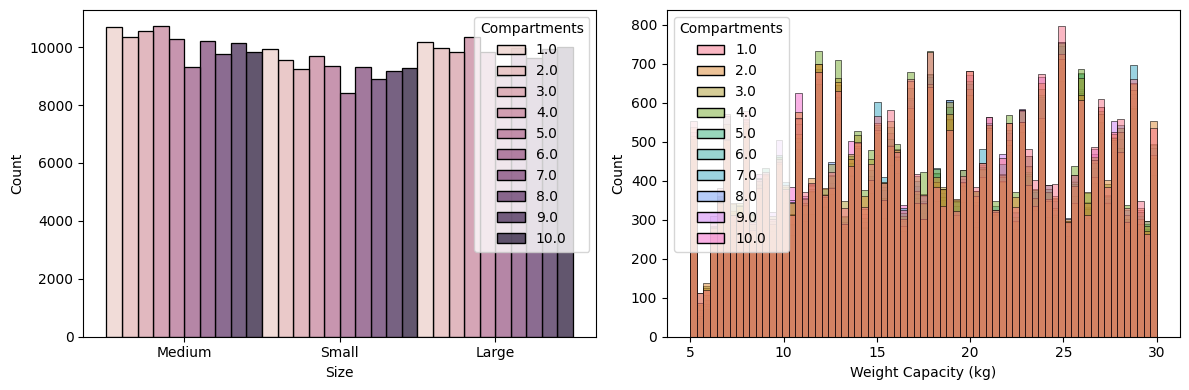

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=play_train, 
    x="Size", 
    hue="Compartments",
    multiple="dodge",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Weight Capacity (kg)", 
    hue="Compartments",
    palette=sns.color_palette("husl", 10),
    edgecolor="k",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

## Style & Color

In [23]:
detail_columns(play_train, "Style")
print("-"* 39)
detail_columns(play_train, "Color")

Variable:  Style 
Format:  object 
Number of null values:  7970 
Unique values:  3 
Distribution of values: 
 Style
Messenger    100031
Tote          97438
Backpack      94561
Name: count, dtype: int64
---------------------------------------
Variable:  Color 
Format:  object 
Number of null values:  9950 
Unique values:  6 
Distribution of values: 
 Color
Pink     51690
Gray     50280
Blue     48097
Red      47219
Green    46386
Black    46378
Name: count, dtype: int64


We found null data in both variables. In the case of the style, the values could be taken as "Other styles", or we could fill the values with the mode grouping by brand. We could apply the same in the case of color, but filling with the average or the mode would complete the values, not considering this relevant variable, although a comparison with price could verify it.

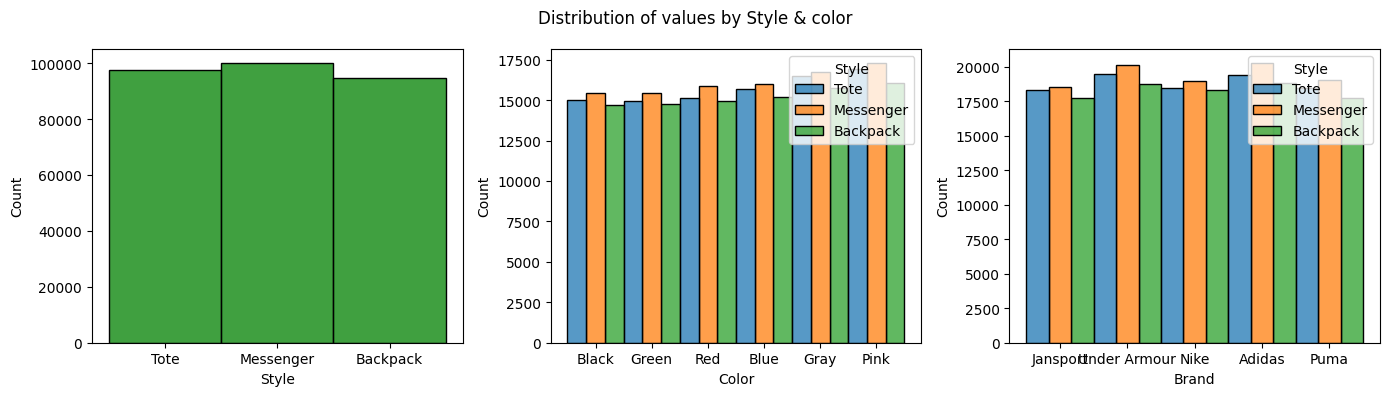

In [24]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

sns.histplot(
    data=play_train, 
    x="Style", 
    color="green",
    edgecolor="k",
    ax=axes[0]
)

sns.histplot(
    data=play_train, 
    x="Color",
    hue="Style",
    multiple="dodge",
    edgecolor="k",
    ax=axes[1]
)

sns.histplot(
    data=play_train, 
    x="Brand",
    hue="Style",
    multiple="dodge",
    edgecolor="k",
    ax=axes[2]
)

plt.suptitle(t="Distribution of values by Style & color")
plt.tight_layout()
plt.show()

We can see that no matter how we group the data, the value "messenger" predominates as the mode. We will complete the color data by grouping by style and analyze how the values are distributed.

## Price (Target variable)

In [25]:
detail_columns(play_train, "Price")

Variable:  Price 
Format:  float64 
Number of null values:  0 
Unique values:  48212 
Distribution of values: 
 Price
150.00000    5528
15.00000      693
23.59584       22
17.31514       21
62.36063       21
             ... 
82.31121        1
90.79389        1
111.37389       1
94.99611        1
41.96325        1
Name: count, Length: 48212, dtype: int64


Our target variable, which represents the different values of each product. We did not find null data.

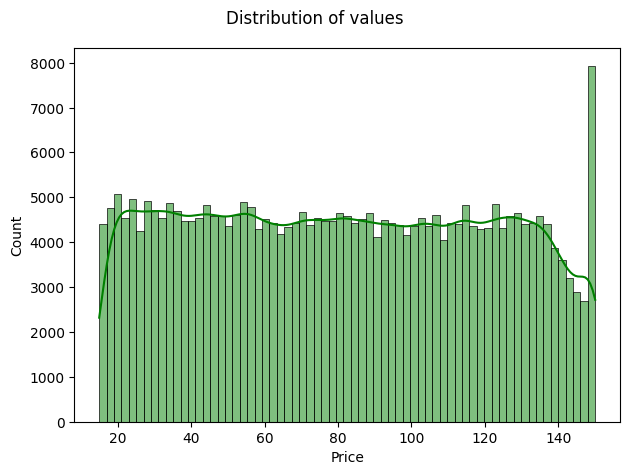

In [26]:
# We analyze the distribution of the data

sns.histplot(
    data=play_train, 
    x="Price", 
    color="green",
    edgecolor="k",
    kde=True
)

plt.suptitle(t="Distribution of values")
plt.tight_layout()
plt.show()

# Data wrangling

In [27]:
# We make a copy of the original dataset

play_new = play_train.copy()

In [28]:
# We check that no duplicate data is found

print(f'Length: {len(play_new.duplicated())}')

print(f'Duplicates: {play_new.duplicated().sum()}')

Length: 300000
Duplicates: 0


In [29]:
# We check the null values

null_values = (
    pd.DataFrame(
        {f'Amount of Null Data' : play_new.isnull().sum(), 
         'Percentage of Null Data' : (
             play_new.isnull().sum()) / (len(play_new)) * (100)
        }))

null_values.style.background_gradient(cmap='Greens')

,Amount of Null Data,Percentage of Null Data
id,0,0.000000
Brand,9705,3.235000
Material,8347,2.782333
Size,6595,2.198333
Compartments,0,0.000000
Laptop Compartment,7444,2.481333
Waterproof,7050,2.350000
Style,7970,2.656667
Color,9950,3.316667
Weight Capacity (kg),138,0.046000


We found 2 to 3 percent of missing data. We could get rid of this data, the missing percentage being so small, but we will try to complete this data so that we do not lose any samples.

## Brand

In [30]:
play_new["Brand"].fillna(play_new["Brand"].mode()[0], inplace=True)

play_new["Brand"].value_counts()

Brand
Adidas          69782
Under Armour    59992
Nike            57336
Puma            56814
Jansport        56076
Name: count, dtype: int64

## Material

In [31]:
play_new["Material"].fillna(play_new["Material"].mode()[0], inplace=True)

play_new["Material"].value_counts()

Material
Polyester    87977
Leather      73416
Nylon        70603
Canvas       68004
Name: count, dtype: int64

## Waterproof

In [32]:
# We fill null values with the mode groupby Material

play_new["Waterproof"] = (
    play_new["Waterproof"].fillna(
        play_new.groupby("Material")["Waterproof"].transform(lambda v: v.mode()[0])
    )
)

print(
        "Number of null values: ", play_new["Waterproof"].isnull().sum(), "\n\n",
        "Distribution of values: \n", play_new["Waterproof"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Waterproof
Yes    155127
No     144873
Name: count, dtype: int64


## Weight Capacity (kg)

In [33]:
# We fill null values with the mode groupby product compartments

play_new["Weight Capacity (kg)"] = (
    play_new["Weight Capacity (kg)"].fillna(
        play_new.groupby("Compartments")["Weight Capacity (kg)"].transform("mean")
    )
)

print(
        "Number of null values: ", play_new["Weight Capacity (kg)"].isnull().sum(), "\n\n",
        "Unique values: ", play_new["Weight Capacity (kg)"].nunique()
)

Number of null values:  0 

 Unique values:  181606


## Size

In [34]:
# We fill null values with the mean

play_new["Size"].fillna(play_new["Size"].mode()[0], inplace=True)

print(
        "Number of null values: ", play_new["Size"].isnull().sum(), "\n\n",
        "Distribution of values: \n", play_new["Size"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Size
Medium    108501
Large      98643
Small      92856
Name: count, dtype: int64


## Laptop Compartment

In [35]:
# We fill null values with the mode groupby the Weight Capacity Group

play_new["Laptop Compartment"].fillna(play_new["Laptop Compartment"].mode()[0], inplace=True)

print(
        "Number of null values: ", play_new["Laptop Compartment"].isnull().sum(), "\n\n",
        "Distribution of values: \n", play_new["Laptop Compartment"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Laptop Compartment
Yes    155786
No     144214
Name: count, dtype: int64


## Style

In [36]:
# We fill null values with the mode groupby Brand

play_new["Style"] = (
    play_new["Style"].fillna(
        play_new.groupby("Brand")["Style"].transform(lambda v: v.mode()[0])
    )
)

print(
        "Number of null values: ", play_new["Style"].isnull().sum(), "\n\n",
        "Distribution of values: \n", play_new["Style"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Style
Messenger    108001
Tote          97438
Backpack      94561
Name: count, dtype: int64


## Color

In [37]:
# We fill null values with the mode groupby Style

play_new["Color"] = (
    play_new["Color"].fillna(
        play_new.groupby("Style")["Color"].transform(lambda v: v.mode()[0])
    )
)

print(
        "Number of null values: ", play_new["Color"].isnull().sum(), "\n\n",
        "Distribution of values: \n", play_new["Color"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Color
Pink     61640
Gray     50280
Blue     48097
Red      47219
Green    46386
Black    46378
Name: count, dtype: int64


In [38]:
play_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  object 
 2   Material              300000 non-null  object 
 3   Size                  300000 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  object 
 6   Waterproof            300000 non-null  object 
 7   Style                 300000 non-null  object 
 8   Color                 300000 non-null  object 
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


# Hypothesis

Next we will try to ask some questions of interest to understand the data in more depth and how the variables are related. We will pose some hypotheses and try to get some answers about the data.

- What price differences do we find by brand?

- What price range does each brand handle in their different products?

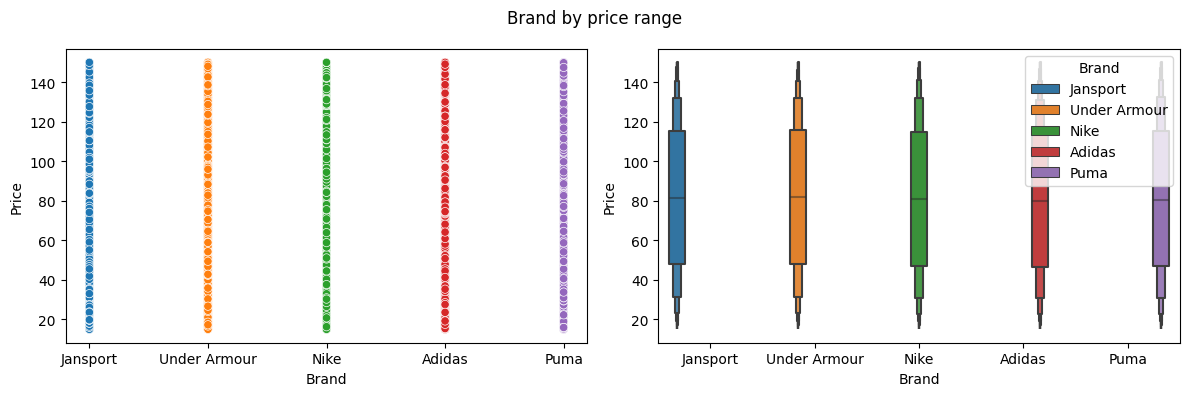

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.scatterplot(
    data=play_new,
    x="Brand",
    y="Price",  
    hue="Brand", 
    legend=False,
    ax=axes[0]
)

sns.boxenplot(
    data=play_new,
    x="Brand",
    y="Price",
    hue="Brand",
    #legend=False,
    ax=axes[1]
)

plt.suptitle(t="Brand by price range")
plt.tight_layout()
plt.show()

Extending the analysis would not be necessary, we can clearly observe that there is a similar, almost exact distribution, not only in price, but also in the price range of the different products by brand.

- Is there any influence on the price depending on the materials?

- How do different materials impact the other variables and how does this affect the price?

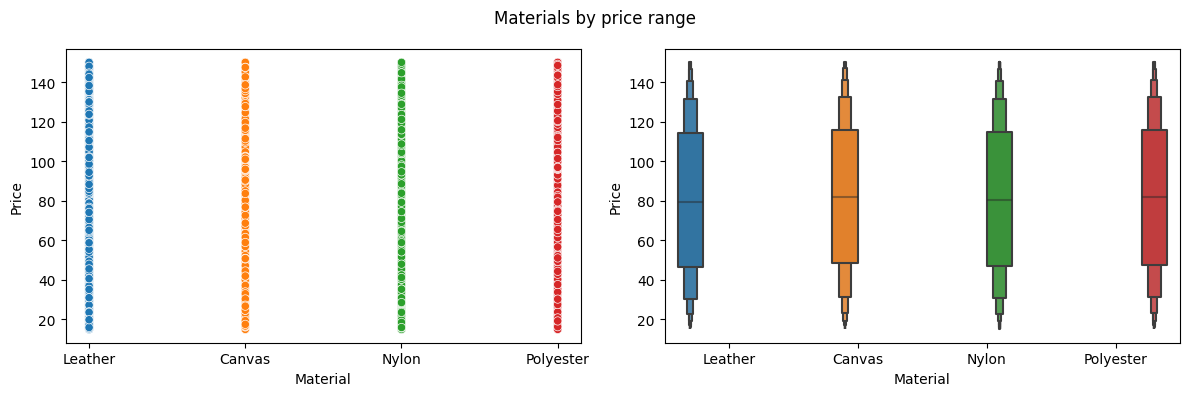

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.scatterplot(
    data=play_new,
    x="Material",
    y="Price",  
    hue="Material", 
    legend=False,
    ax=axes[0]
)

sns.boxenplot(
    data=play_new,
    x="Material",
    y="Price",
    hue="Material",
    #legend=False,
    ax=axes[1]
)

axes[1].get_legend().set_visible(False)
plt.suptitle(t="Materials by price range")
plt.tight_layout()
plt.show()

We had already been able to analyze this result previously in the EDA, where we also included the "Waterproof" variable. We found no differences in how materials are distributed by price.

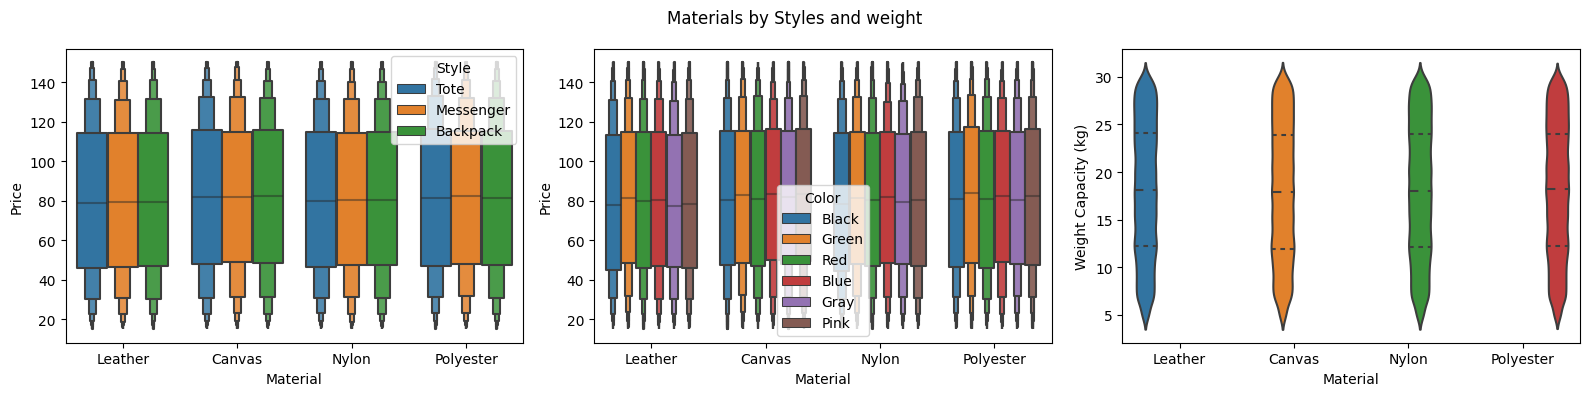

In [41]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

sns.boxenplot(
    data=play_new,
    x="Material",
    y="Price",  
    hue="Style", 
    ax=axes[0]
)

sns.boxenplot(
    data=play_new,
    x="Material",
    y="Price",
    hue="Color",
    ax=axes[1]
)

sns.violinplot(
    data=play_new,
    x="Material",
    y="Weight Capacity (kg)",
    hue="Material",
    inner="quart",
    ax=axes[2]
)


axes[2].get_legend().set_visible(False)
plt.suptitle(t="Materials by Styles and weight")
plt.tight_layout()
plt.show()

We found no differences in weight capacity by material in terms of price. We found some outliers for the classes we created from the missing data. But except for some price variations in the case of colors, nothing relevant in terms of styles.

- Is the size and capacity a condition for the price of the product?

- How does the price affect the number of compartments?

- Is there any special condition or style that impacts the price of the product?

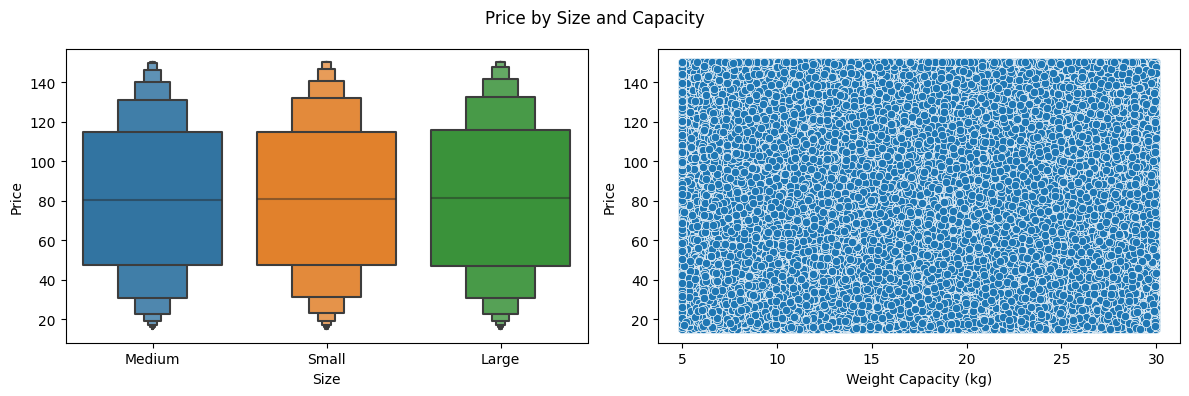

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.boxenplot(
    data=play_new,
    x="Size",
    y="Price",  
    ax=axes[0]
)

sns.scatterplot(
    data=play_new,
    x="Weight Capacity (kg)",
    y="Price",
    ax=axes[1]
)

plt.suptitle(t="Price by Size and Capacity")
plt.tight_layout()
plt.show()

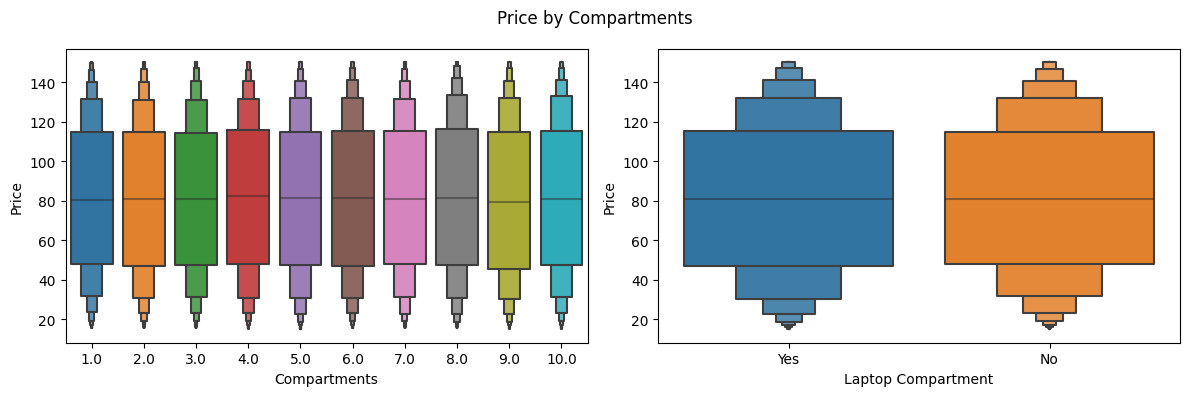

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.boxenplot(
    data=play_new,
    x="Compartments",
    y="Price",  
    ax=axes[0]
)

sns.boxenplot(
    data=play_new,
    x="Laptop Compartment",
    y="Price",
    ax=axes[1]
)

plt.suptitle(t="Price by Compartments")
plt.tight_layout()
plt.show()

We found no differences in price depending on size or even capacity. Nor do we see marked differences depending on the different compartments or their quantity, in the price of the product.

# Encoding And Scaling

In [44]:
play_end = play_new.copy()

In [45]:
# We map the variable and change the format

m_size = {"Small" : 0, "Medium" : 1, "Large" : 2}
play_end["Size"] = play_end["Size"].map(m_size)
play_end["Size"] = play_end["Size"].astype("float64")

In [46]:
# We apply LabelEncoder to columns with multiple classes

le = LabelEncoder()

play_end["Brand"] = le.fit_transform(play_end["Brand"])
play_end["Material"] = le.fit_transform(play_end["Material"])
play_end["Style"] = le.fit_transform(play_end["Style"])
play_end["Color"] = le.fit_transform(play_end["Color"])

In [47]:
# We create a df with the categorical variables

df_category = play_end[[
    "Laptop Compartment",
    "Waterproof"
]]

# We create the encoder

encoder = OneHotEncoder(sparse=False, drop="if_binary")

# We adjust and transform the data

df_cat_encoded = encoder.fit_transform(df_category)

# We convert the result to a Pandas DataFrame with the column names

df_cat_encoded = pd.DataFrame(
    df_cat_encoded, columns=encoder.get_feature_names_out(df_category.columns)
)

# We correct the names of the columns

df_cat_encoded.rename(
    columns={
        "Laptop Compartment_Yes" : "Laptop Compartment",
        "Waterproof_Yes" : "Waterproof",
    }, inplace=True)

df_cat_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Laptop Compartment  300000 non-null  float64
 1   Waterproof          300000 non-null  float64
dtypes: float64(2)
memory usage: 4.6 MB


In [48]:
# Numerical variables to scale

df_numeric = play_end[["Weight Capacity (kg)"]]

# We transform the data

rs = RobustScaler()

num_rs = rs.fit_transform(df_numeric)

df_scale = pd.DataFrame(
    num_rs, columns=rs.get_feature_names_out(df_numeric.columns)
)

In [49]:
# We create a df with the remaining variables

df_rest = play_end[[
    "Brand",
    "Material",
    "Style",
    "Color",
    "Size", 
    "Compartments",
    "Price"
]]

# We concatenate the dataframes

df_backpack = pd.concat([df_rest, df_cat_encoded, df_scale], axis=1)

In [50]:
df_backpack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 300000 non-null  int64  
 1   Material              300000 non-null  int64  
 2   Style                 300000 non-null  int64  
 3   Color                 300000 non-null  int64  
 4   Size                  300000 non-null  float64
 5   Compartments          300000 non-null  float64
 6   Price                 300000 non-null  float64
 7   Laptop Compartment    300000 non-null  float64
 8   Waterproof            300000 non-null  float64
 9   Weight Capacity (kg)  300000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 22.9 MB


In [51]:
df_backpack.corr().style.background_gradient(cmap='Greens')

,Brand,Material,Style,Color,Size,Compartments,Price,Laptop Compartment,Waterproof,Weight Capacity (kg)
Brand,1.000000,0.002290,0.000614,-0.002596,0.000050,-0.003434,0.008998,0.003356,0.002558,0.001592
Material,0.002290,1.000000,0.001678,0.002768,-0.001340,-0.001524,0.002136,0.005464,0.000666,0.007523
Style,0.000614,0.001678,1.000000,-0.000145,0.004442,0.007299,-0.000290,0.000175,-0.000381,0.001799
Color,-0.002596,0.002768,-0.000145,1.000000,-0.002755,-0.001850,0.003688,0.000724,-0.001128,-0.000380
Size,0.000050,-0.001340,0.004442,-0.002755,1.000000,0.005805,0.002400,0.000133,-0.000621,0.001659
Compartments,-0.003434,-0.001524,0.007299,-0.001850,0.005805,1.000000,-0.000131,-0.003252,-0.004778,0.002543
Price,0.008998,0.002136,-0.000290,0.003688,0.002400,-0.000131,1.000000,-0.001321,-0.003984,0.018014
Laptop Compartment,0.003356,0.005464,0.000175,0.000724,0.000133,-0.003252,-0.001321,1.000000,-0.027695,0.003611
Waterproof,0.002558,0.000666,-0.000381,-0.001128,-0.000621,-0.004778,-0.003984,-0.027695,1.000000,0.004567
Weight Capacity (kg),0.001592,0.007523,0.001799,-0.000380,0.001659,0.002543,0.018014,0.003611,0.004567,1.000000


In [52]:
# We separate the target variable from the features

x_backpack = df_backpack.drop(columns="Price")
y_backpack = df_backpack["Price"]

In [53]:
mi_scores = mutual_info_regression(x_backpack, y_backpack)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_backpack.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Color                   0.027630
Brand                   0.020774
Material                0.017624
Style                   0.016103
Weight Capacity (kg)    0.015790
Compartments            0.014996
Size                    0.012960
Laptop Compartment      0.006097
Waterproof              0.004802
Name: MI Scores, dtype: float64

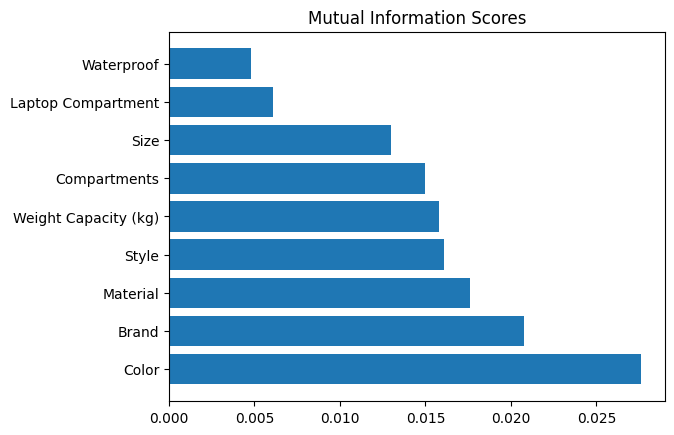

<Figure size 800x500 with 0 Axes>

In [54]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()

# Model Selection

In [55]:
# We separate the data into training and test sets

x_train, x_test, y_train, y_test = (
    train_test_split(
        x_backpack, y_backpack, test_size=0.2, random_state=42
    )
)

## ExtraTreesRegressor

In [56]:
# We create the model instance

#etr = ExtraTreesRegressor()

# Train the model with the data

#etr.fit(x_train, y_train)

In [57]:
#y_pred_etr = etr.predict(x_test)

#r2_etr = r2_score(y_test, y_pred_etr)

#rmse_etr = np.sqrt(mean_squared_error(y_test, y_pred_etr))

#print(f"ExtraTreesRegressor\n\nR-squared score: {r2_etr}\nRMSE: {rmse_etr}")

In [58]:
# Evaluate the model using cross-validation

#cv_scores_etr = cross_val_score(etr, x_train, y_train, cv=5)

#print(f"Cross-validation scores: {cv_scores_etr}")
#print(f"Mean CV accuracy: {np.mean(cv_scores_etr):.2f}")

In [59]:
# Create the KFold object

#kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [60]:
# We evaluate the model with the KFold method

#kfold_scores_etr = cross_val_score(etr, x_train, y_train, cv=kfold)

#print(f"Cross-validation Kfold scores: {kfold_scores_etr}")
#print(f"Mean CV-kfold accuracy: {np.mean(kfold_scores_etr):.2f}")

ExtraTreesRegressor (Version 8)

R-squared score: -0.6016405395290232

RMSE: 49.2856326785476

Cross-validation scores: [-0.59637728 -0.60245314 -0.59410088 -0.59906486 -0.60480837]

Mean CV accuracy: -0.60

Cross-validation Kfold scores: [-0.59343481 -0.57695987 -0.5928216  -0.56913568 -0.58226055]

Mean CV-kfold accuracy: -0.58

ExtraTreesRegressor (Version 9)

R-squared score: -0.23984548677773598

RMSE: 43.36322682719241

Cross-validation scores: [-0.22926731 -0.22042813 -0.2370963  -0.23276077 -0.23061222]

Mean CV accuracy: -0.23

Cross-validation Kfold scores: [-0.21818748 -0.22456707 -0.23000293 -0.22792196 -0.23651784]

Mean CV-kfold accuracy: -0.23

## BaggingRegressor

In [61]:
# We create the model instance

#bagr = BaggingRegressor(base_estimator=etr)

# Train the model with the data

#bagr.fit(x_train, y_train)

In [62]:
#y_pred_bagr = bagr.predict(x_test)

#r2_bagr = r2_score(y_test, y_pred_bagr)

#rmse_bagr = np.sqrt(mean_squared_error(y_test, y_pred_bagr))

#print(f"BaggingRegressor\n\nR-squared score: {r2_bagr}\nRMSE: {rmse_bagr}")

BaggingRegressor (Version 8)

R-squared score: -0.33549522390497266

RMSE: 45.0048148292323

BaggingRegressor (Version 9)

R-squared score: -0.12530694213710114

RMSE: 41.31172299925306

## KNeighborsRegressor

In [63]:
'''
error_rate = []

for i in range(1,10):
    knr = KNeighborsRegressor(n_neighbors=i)
    knr.fit(x_train, y_train)
    pred = knr.predict(x_test)
    error_rate.append(np.mean(pred != y_test))

plt.figure(figsize=(12,4))
plt.plot(range(1,10),error_rate, marker='o', markersize=9)
'''

"\nerror_rate = []\n\nfor i in range(1,10):\n    knr = KNeighborsRegressor(n_neighbors=i)\n    knr.fit(x_train, y_train)\n    pred = knr.predict(x_test)\n    error_rate.append(np.mean(pred != y_test))\n\nplt.figure(figsize=(12,4))\nplt.plot(range(1,10),error_rate, marker='o', markersize=9)\n"

In [64]:
# We create the model instance

#knr = KNeighborsRegressor(n_neighbors=2)

# Train the model with the data

#knr.fit(x_train, y_train)

In [65]:
#y_pred_knr = knr.predict(x_test)

#r2_knr = r2_score(y_test, y_pred_knr)

#rmse_knr = np.sqrt(mean_squared_error(y_test, y_pred_knr))

#print(f"KNeighborsRegressor\n\nR-squared score: {r2_knr}\nRMSE: {rmse_knr}")

KNeighborsRegressor (Version 8)

R-squared score: -0.506566188092598

RMSE: 47.80044257843118

KNeighborsRegressor (Version 9)

R-squared score: -0.4975634948865224

RMSE: 47.657409524479995

## LinearRegression

In [66]:
# We create the model instance

#lr = LinearRegression()

# Train the model with the data

#lr.fit(x_train, y_train)

In [67]:
#y_pred_lr = lr.predict(x_test)

#r2_lr = r2_score(y_test, y_pred_lr)

#rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

#print(f"KNeighborsRegressor\n\nR-squared score: {r2_lr}\nRMSE: {rmse_lr}")

KNeighborsRegressor (Version 10)

R-squared score: 0.0005435476018272878

RMSE: 38.933168341468516

## Lightgbm

In [68]:
# We create the model instance

lgbr = LGBMRegressor(max_depth=2, num_leaves=24, verbose=0)

# Train the model with the data

lgbr.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMRegressor(max_depth=2, num_leaves=24, verbose=0)

In [69]:
y_pred_lgbr = lgbr.predict(x_test)

r2_lgbr = r2_score(y_test, y_pred_lgbr)

rmse_lgbr = np.sqrt(mean_squared_error(y_test, y_pred_lgbr))

print(f"LGBMRegressor\n\nR-squared score: {r2_lgbr}\nRMSE: {rmse_lgbr}")

LGBMRegressor

R-squared score: 0.0013221678236161605
RMSE: 38.91800006754865


LGBMRegressor (default)

R-squared score: 0.000548929202235926 -- RMSE: 38.933063522976326

LGBMRegressor (max_depth=1)

R-squared score: 0.0010940864856743282 -- RMSE: 38.92244392446024

LGBMRegressor (max_depth=1, num_leaves=50)

R-squared score: 0.00041789589889951184 -- RMSE: 38.93561560425031

LGBMRegressor (max_depth=2, num_leaves=24)

R-squared score: 0.0013221678236161605 -- RMSE: 38.91800006754865

LGBMRegressor (num_leaves=24, verbose=0)

R-squared score: 0.0009063122152497272 -- RMSE: 38.926102071826946

# Test dataset

In [70]:
# We load the test data

df_test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

In [71]:
# We check the shape and that no duplicate data is found

print(f"Length: {len(df_test.duplicated())}")

print(f"Duplicates: {df_test.duplicated().sum()}")

print(f"Shape: {df_test.shape}")

Length: 200000
Duplicates: 0
Shape: (200000, 10)


In [72]:
# We start by removing the variables that we will not use

df_test_clean = df_test.drop(columns=["id"])

In [73]:
# We check the null values

null_values_test = (
    pd.DataFrame(
        {f'Amount of Null Data' : df_test_clean.isnull().sum(), 
         'Percentage of Null Data' : (
             df_test_clean.isnull().sum()) / (len(df_test_clean)) * (100)
        }
    ))

null_values_test.style.background_gradient(cmap='Greens')

,Amount of Null Data,Percentage of Null Data
Brand,6227,3.113500
Material,5613,2.806500
Size,4381,2.190500
Compartments,0,0.000000
Laptop Compartment,4962,2.481000
Waterproof,4811,2.405500
Style,5153,2.576500
Color,6785,3.392500
Weight Capacity (kg),77,0.038500


In [74]:
df_test_clean["Brand"].fillna(df_test_clean["Brand"].mode()[0], inplace=True)

df_test_clean["Material"].fillna(df_test_clean["Material"].mode()[0], inplace=True)

df_test_clean["Waterproof"] = df_test_clean["Waterproof"].fillna(
        df_test_clean.groupby("Material")["Waterproof"].transform(lambda v: v.mode()[0])
)
df_test_clean["Weight Capacity (kg)"] = df_test_clean["Weight Capacity (kg)"].fillna(
        df_test_clean.groupby("Compartments")["Weight Capacity (kg)"].transform("mean")
)
df_test_clean["Size"].fillna(df_test_clean["Size"].mode()[0], inplace=True)

df_test_clean["Laptop Compartment"].fillna(df_test_clean["Laptop Compartment"].mode()[0], inplace=True)

df_test_clean["Style"] = df_test_clean["Style"].fillna(
        df_test_clean.groupby("Brand")["Style"].transform(lambda v: v.mode()[0])
)
df_test_clean["Color"] = df_test_clean["Color"].fillna(
        df_test_clean.groupby("Style")["Color"].transform(lambda v: v.mode()[0])
)

df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 200000 non-null  object 
 1   Material              200000 non-null  object 
 2   Size                  200000 non-null  object 
 3   Compartments          200000 non-null  float64
 4   Laptop Compartment    200000 non-null  object 
 5   Waterproof            200000 non-null  object 
 6   Style                 200000 non-null  object 
 7   Color                 200000 non-null  object 
 8   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), object(7)
memory usage: 13.7+ MB


In [75]:
test_m_size = {"Small" : 0, "Medium" : 1, "Large" : 2}
df_test_clean["Size"] = df_test_clean["Size"].map(test_m_size)
df_test_clean["Size"] = df_test_clean["Size"].astype("float64")

df_test_clean["Brand"] = le.fit_transform(df_test_clean["Brand"])
df_test_clean["Material"] = le.fit_transform(df_test_clean["Material"])
df_test_clean["Style"] = le.fit_transform(df_test_clean["Style"])
df_test_clean["Color"] = le.fit_transform(df_test_clean["Color"])

test_category = df_test_clean[[
    "Laptop Compartment",
    "Waterproof"
]]

test_cat_encoded = encoder.fit_transform(test_category)

test_cat_encoded = pd.DataFrame(
    test_cat_encoded, columns=encoder.get_feature_names_out(test_category.columns)
)

test_cat_encoded.rename(
    columns={
        "Laptop Compartment_Yes" : "Laptop Compartment",
        "Waterproof_Yes" : "Waterproof",
    }, inplace=True)

test_numeric = df_test_clean[["Weight Capacity (kg)"]]

test_num_rs = rs.fit_transform(test_numeric)

test_scale = pd.DataFrame(
    test_num_rs, columns=rs.get_feature_names_out(test_numeric.columns)
)

test_rest = df_test_clean[[
    "Brand",
    "Material",
    "Style",
    "Color",
    "Size", 
    "Compartments"
]]

# We concatenate the dataframes

test_end = pd.concat([test_rest, test_cat_encoded, test_scale], axis=1)

test_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 200000 non-null  int64  
 1   Material              200000 non-null  int64  
 2   Style                 200000 non-null  int64  
 3   Color                 200000 non-null  int64  
 4   Size                  200000 non-null  float64
 5   Compartments          200000 non-null  float64
 6   Laptop Compartment    200000 non-null  float64
 7   Waterproof            200000 non-null  float64
 8   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 13.7 MB


In [76]:
# We apply the trained model

test_predictions = lgbr.predict(test_end)

In [77]:
# We review the result

print('Total predictions: ', len(test_predictions), '\n')

Total predictions:  200000 



In [78]:
# We create the dataframe

df_submission = pd.DataFrame({
    'id' : df_test['id'], 
    'Price' : test_predictions
})

df_submission.head(10)

,id,Price
0,300000,81.844176
1,300001,82.306640
2,300002,81.546806
3,300003,81.488180
4,300004,78.353955
5,300005,82.424155
6,300006,82.466187
7,300007,82.745162
8,300008,82.427351
9,300009,80.282306


In [79]:
# We load the test data

sample_s = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")

In [80]:
sample_s.head()

,id,Price
0,300000,81.411
1,300001,81.411
2,300002,81.411
3,300003,81.411
4,300004,81.411


In [81]:
# We review the results

print(
    f"Shape sample_submission: {sample_s.shape}",
    f"\nShape test_predictions: {df_submission.shape}"
)

Shape sample_submission: (200000, 2) 
Shape test_predictions: (200000, 2)


In [82]:
# We convert the dataframe to a csv file

df_submission.to_csv("submission.csv", index=False)